## Plots for Barcharts

#### Content
[Coding Productivity Plots](#codeprod)  


##### Packages and main formatting parameters

In [6]:
# executed in conda evnironment 'plotting' ./conda_envs/plotting

# packages and overall options
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.lines as lines
import matplotlib.patches as patches
import matplotlib.lines as mlines
import glob
import json
import sys

bol_paper = True

if bol_paper:
    sns.set(style='white', font='serif', font_scale=1.5)
    # fontsize for annotation
    font_size = 14
    fig_width = 9
    fig_height = 4.5
    # Set Seaborn style without grid
    plt.rcParams['xtick.major.size'] = 4
    plt.rcParams['ytick.major.size'] = 4
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True   
    # out path
    out_folder = ''
    legend_anchor=1.2
else:
    sns.set(style='white', font='sans serif', font_scale=1.3)
    # fontsize for annotation
    font_size = 14
    # figur width and height
    fig_width = 10
    fig_height = 4
    # Set Seaborn style without grid
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
    # out path
    out_folder = 'presentations'
    legend_anchor=1.2

# colors
# custom_palette = sns.color_palette('colorblind')
# we use the IBM color design which looks ok for all:https://forum.shotcut.org/t/palette-for-colour-blindness/32219
ibm_colors_hex = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']

import matplotlib.colors as mcolors
# Function to lighten colors
def lighten_color(hex_color, factor=0.25):
    """Lightens the given color by blending it with white."""
    rgb = mcolors.hex2color(hex_color)  # Convert to RGB (0-1 range)
    light_rgb = [(1 - factor) * c + factor for c in rgb]  # Blend with white
    return mcolors.to_hex(light_rgb)

# Generate lightened versions of IBM colors
light_ibm_colors_hex = [lighten_color(color, factor=0.25) for color in ibm_colors_hex]

# Add three shades of grey
grey_shades = ['#D3D3D3', '#A9A9A9', '#696969']

# Combine into an extended color palette
extended_colors = ibm_colors_hex + grey_shades + light_ibm_colors_hex

custom_palette = sns.color_palette(extended_colors)

# annotateion color on columns
annotate_color='black'


##### Helper functions

In [41]:
def format_with_decimals(value, tick_number):
    return f'{value:.1f}'

# general methods
def format_thousands_separator(x, digits):
    # x are the labels (str), if convertable to float its fine.
    try:
        if digits == 0:
            return '{:,.f}'.format(int(round(float(x),0))).replace(',', "'")
        else:
            return '{:,.{}f}'.format(float(x), digits).replace(',', "'")
    except ValueError:
        return x

def formatter(ax, rotation=None):
    # Format the y-axis ticks
    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, _: format_thousands_separator(x, 1)))
    
    ax.tick_params(axis='both', width=0.8)

    if rotation is not None:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right', rotation_mode='anchor')

    # Format legend text (if any)
    if ax.get_legend() is not None:
        for label in ax.get_legend().get_texts():
            label.set_text(format_thousands_separator(label.get_text(), 1))  

def make_grid(ax, plt, ygrid=True, xgrid=False):
    ax.yaxis.grid(ygrid)  # Enable the grid
    ax.xaxis.grid(xgrid)  # Enable the grid
    plt.setp(ax.get_ygridlines(), 'linestyle', '-')  # Set grid line style
    plt.setp(ax.get_ygridlines(), 'linewidth', 0.5)  # Set grid line width
    plt.setp(ax.get_ygridlines(), 'color', 'gray', 'alpha', 0.5)  # Set grid line color
    
    # Enhance grid visibility beneath the bars
    ax.set_axisbelow(True)    
    
    # Customize the box line width
    ax.spines['top'].set_linewidth(0.8)
    ax.spines['right'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    ax.spines['left'].set_linewidth(0.8)

    # Customize tick parameters
    ax.tick_params(axis='both', width=0.5, length=3)

def annotater(ax, plt, digits = 0, annotation_rotated = False):
    
    rot = 90 if annotation_rotated else 0
    division = 1 if annotation_rotated else 20  # smaller for better vertical control
    
    # compute max height for relative placement
    max_height = max((p.get_height() for p in ax.patches if p.get_height() > 0), default=1)          
    
    for p in ax.patches:
            height = p.get_height()
            if height > 0:
                # Center horizontally
                x_position = p.get_x() + p.get_width() / 2

                # Slight offset above bar, proportional to height or overall max
                y_offset = max_height / division
                y_position = height + y_offset

                label = format_thousands_separator(height, digits)

                plt.text(
                    x_position,
                    y_position,
                    label,
                    ha='center',
                    va='bottom',
                    rotation=rot,
                    color=annotate_color,
                    fontsize=font_size,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=1, pad=0.1)
                )
            
def finisher(plot_name, plt):
    # Remove the top and right spines
    #sns.despine(top=True, right=True)   

    # pack everthing into the plot size
    plt.tight_layout()

    # Save the plot as SVG
    plt.savefig(os.path.join(path_svg,out_folder,plot_name + '.svg'), format='svg', bbox_inches='tight')
    plt.show()

import matplotlib.lines as lines

## Coding Productivity Plots
<a id='codeprod'></a>

Used to create the plots for the coding productivity metrics:
* Source line of code (SLOC)
* Tokens (TOK)
* Cyclomatic Complexity (CCN)
* Halstead Effort (HAL)

### Read and parse the output for each code produced with *multimetric* tool

In [48]:
# load and read data
path_json = '../coding_productivity/metrics/'

# file name to text mapper
mapper = {
    'cc': 'Connected Components',
    'cpp': 'C++\n(cpp)',
    'jl': 'Julia\n(jl)',
    'py': 'Python\n(py)',
    'daph': 'DaphneDSL\n(daph)',
    'seq': 'Seq',
    'par': 'Par',
    'mpi': 'Dist',
}

# all JSON files
all_files = glob.glob(os.path.join(path_json,'*.json'))

# read all JSON files and combine them into a single DataFrame
df_list = []
print(all_files)
for filepath in all_files:
    
    filename = os.path.basename(filepath)  # Get the filename from the full path

    # get information about the algorithm, the language and the type from the filename
    algo = mapper.get(filename.split('_')[0], pd.NA)
    lang = mapper.get(filename.split('_')[1], pd.NA)
    typ = mapper.get(filename.split('_')[2].split('.')[0], pd.NA)
    
    # dataframe column names
    col_names=['benchmark',
           'language',
           'type',
           'SLOC',
           'N1',
           'N2',
           'TOC',
           'n1',
           'n2',
           'HAL',
           'CCN']
    
    # load the JSON file
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    # find the first (and only) file entry
    file_metrics = next(iter(data['files'].values()))

    # extract your desired metrics
    sloc = file_metrics.get('sloc')
    cyclomatic = file_metrics.get('cyclomatic_complexity')
    halstead_effort = file_metrics.get('halstead_effort')

    n1 = file_metrics.get('operators_uniq')
    n2 = file_metrics.get('operands_uniq')
    N1 = file_metrics.get('operators_sum')
    N2 = file_metrics.get('operands_sum')

    toc = N1 + N2  # total operator and operand occurrences

    # create an empty DataFrame with the specified columns
    df = pd.DataFrame(columns=col_names)
    # insert values into the first row (index 0)
    df.loc[0] = [
        algo,        # benchmark
        lang,        # language
        typ,         # type
        int(sloc),   # SLOC
        int(N1),     # N1
        int(N2),     # N2
        int(toc),    # TOC
        int(n1),     # n1
        int(n2),     # n2
        float(halstead_effort),  # HAL
        int(cyclomatic)          # CCN
    ]
        
    df_list.append(df)

    # if the language is DaphneDSL, we add the same values for the 'dist' type
    if lang ==  mapper.get('daph'):
        # create a copy of the DataFrame
        df_dist = df.copy()
        # change the type to 'Dist'
        df_dist['type'] = 'Dist'
        # append the new DataFrame to the list
        df_list.append(df_dist)

df_wide = pd.concat(df_list, axis=0, ignore_index=True)

# make it a tidy DataFrame
df_long = pd.melt(
    df_wide,
    id_vars=['benchmark', 'language', 'type'],  # keep these as identifiers
    value_vars=['SLOC', 'N1', 'N2', 'TOC', 'n1', 'n2', 'HAL', 'CCN'],  # metrics to melt
    var_name='metric',
    value_name='value'
)

# show
df_long.head(10)


['../coding_productivity/metrics/cc_cpp_seq.json', '../coding_productivity/metrics/cc_jl_seq.json', '../coding_productivity/metrics/cc_py_mpi.json', '../coding_productivity/metrics/cc_daph_seq.json', '../coding_productivity/metrics/cc_cpp_mpi.json', '../coding_productivity/metrics/cc_jl_mpi.json', '../coding_productivity/metrics/cc_py_seq.json']


,benchmark,language,type,metric,value
0,Connected Components,C++\n(cpp),Seq,SLOC,59.0
1,Connected Components,Julia\n(jl),Seq,SLOC,64.0
2,Connected Components,Python\n(py),Dist,SLOC,99.0
3,Connected Components,DaphneDSL\n(daph),Seq,SLOC,12.0
4,Connected Components,DaphneDSL\n(daph),Dist,SLOC,12.0
5,Connected Components,C++\n(cpp),Dist,SLOC,151.0
6,Connected Components,Julia\n(jl),Dist,SLOC,99.0
7,Connected Components,Python\n(py),Seq,SLOC,23.0
8,Connected Components,C++\n(cpp),Seq,N1,323.0
9,Connected Components,Julia\n(jl),Seq,N1,177.0


#### Overall runtime for different number of targets and cores

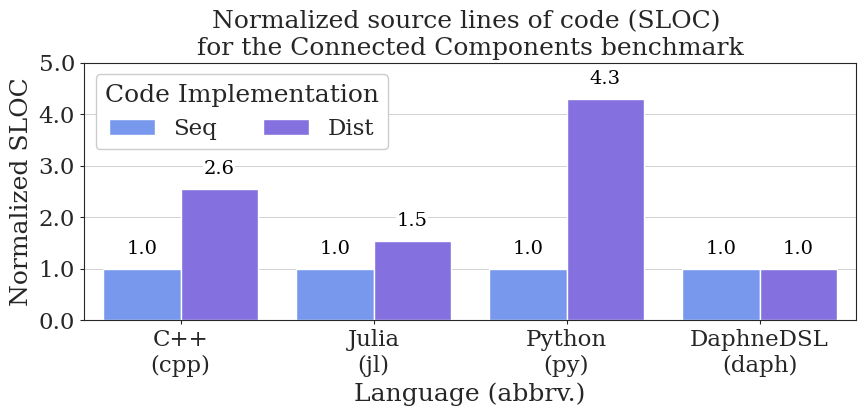

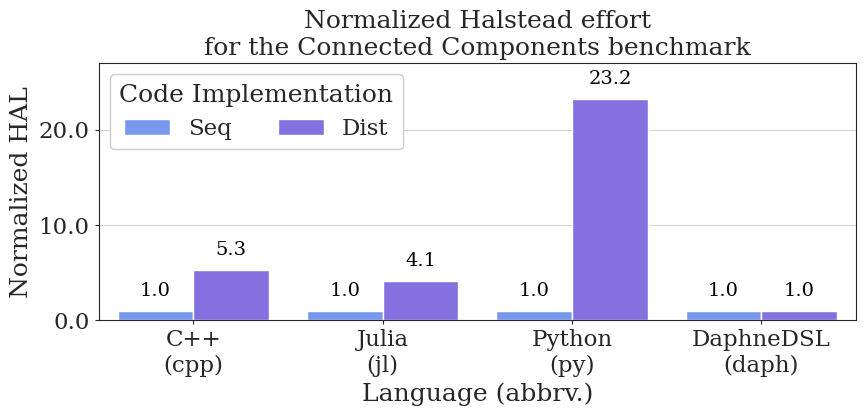

In [ ]:
# output path for svg plots
path_svg = './coding_productivity/'

# plots are procuded in loops

plot_loop = {
    'cc_sloc' : {
        'on_y' : 'value',
        'on_y_label' : 'Normalized SLOC',
        'on_x' : 'language',
        'on_x_label' : 'Language (abbrv.)',
        'on_hue' : 'type',
        'on_hue_label' : 'Code Implementation',        
        'columns' : ['value', 'language', 'type'],
        'filter_cols' : [
            ('benchmark', ['Connected Components']),
            ('metric', ['SLOC']),
        ],
        'title' : 'Normalized source lines of code (SLOC) \nfor the Connected Components benchmark',
        'loc' : 'upper left',    
        'ylim' : [0, 5]   
    },
    'cc_hal' : {
        'on_y' : 'value',
        'on_y_label' : 'Normalized HAL',
        'on_x' : 'language',
        'on_x_label' : 'Language (abbrv.)',
        'on_hue' : 'type',
        'on_hue_label' : 'Code Implementation',        
        'columns' : ['value', 'language', 'type'],
        'filter_cols' : [
            ('benchmark', ['Connected Components']),
            ('metric', ['HAL']),
        ],
        'title' : 'Normalized Halstead effort (HAL)\nfor the Connected Components benchmark',
        'loc' : 'upper left',    
        'ylim' : [0, 27]   
    }
}

for k,v in plot_loop.items():
    df = df_long.copy()
    # what we want to display
    on_x = v.get('on_x')
    on_x_label = v.get('on_x_label')
    on_y = v.get('on_y')
    on_y_label= v.get('on_y_label')
    on_hue = v.get('on_hue')
    on_hue_label = v.get('on_hue_label')

    # columns
    columns = v.get('columns')

    ##### Change this and the name to make and save another plot
    filter_cols = v.get('filter_cols') 
    # name of the plot
    title = v.get('title')
    plot_name = '{}'.format(k)

    # to annotate bars
    annotate=True
    # ignored if annotate=False
    annotation_rotated=False

    # Filter data
    for filt in filter_cols:
        if filt[1] is None:
            df = df[(df[filt[0]].isnull())]
        else:
            df = df[(df[filt[0]].isin(filt[1]))]

    # normalize the value column. Devide the rows by the row entry for seq for each language
    df_norm = df.copy()
    # step 1: Create a column with the base "Seq" value per (benchmark, language, metric)
    seq_values = df_norm[df_norm['type'] == 'Seq'].set_index(['benchmark', 'language', 'metric'])['value']
    df_norm['seq_base'] = df_norm.set_index(['benchmark', 'language', 'metric']).index.map(seq_values)

    # step 2: Normalize
    df_norm['normalized'] = df_norm['value'] / df_norm['seq_base']

    df_norm['value'] = df_norm['normalized']
    data = df_norm.drop(columns=['normalized', 'seq_base'])

    # print(df)
    # print(data)
    # sys.exit(0)

    # Plot the bar plot using seaborn
    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.barplot(
        data=data,
        x=on_x,
        y=on_y,
        hue=on_hue,
        estimator=np.mean, 
        errorbar=None,
        # errorbar = lambda x: (x.min(), x.max()), 
        palette=custom_palette[:data[on_hue].nunique()],
        capsize=0.1,  # Controls the size of the caps on the error bars
        err_kws={'color': 'black', 'linewidth': 1} # Width of the error bars       
    )

    # Set plot properties
    plt.xlabel(on_x_label)
    plt.ylabel(on_y_label)

    # Add thin grid lines at y-axis ticks
    make_grid(ax, plt)

    # set y axis limits for plot to fit
    if not v.get('ylim',None) is None:
        l,u = v.get('ylim')
        plt.ylim(l,u)

    # Set the title using plt.title()
    plt.title(title)

    # Place the legend at the top-right corner
    leg = plt.legend(title=on_hue_label, loc=v.get('loc'), ncol=data[on_hue].nunique())
    leg.get_frame().set_alpha(1) 

    # Format the y-axis ticks with a space as a thousand separator
    # Format legend labels with a space as a thousand separator
    formatter(ax)

    # Annotate each bar with the formatted value
    if annotate:
        annotater(ax, plt, 1, annotation_rotated)

    # finish, save and plot
    finisher(plot_name, plt)
